<img align="center" src="https://raw.githubusercontent.com/FUlyankin/Parsers/master/images%20/cats.jpg" height="1200" width="1200"> 

# Мини-домашка 6: регрессия

На семинаре мы пытались спрогнозировать сколько лайков поставит студент первого курса в вышкинский паблик с мемасами. Наша итоговая модель получилась довольно хлипкой. Хотелось бы улучшить её. В этом домашнем задании именно этим вы и займётесь. По ходу кода ниже будет довольно много пустых строк. Нужно заполнить их своим кодом. 

In [64]:
import pandas as pd               # уже знакомый вам пакет для работы с таблицами
import numpy as np                # смутно знакомый вам пакет для работы с матрицами
import matplotlib.pyplot as plt   # уже смутно знакомый вам пакет для картинок :3
import seaborn as sns             # ещё один пакет для картинок 
plt.style.use('ggplot')     # правильный (очень красивый) стиль у графиков

%matplotlib inline

## 1. Гипотеза для раскрутки 

Семинар мы закончили, построив визуализацию для прогнозов. Она получилась вот такой: 

![картинка епта]( )

По оси $x$ мы отклаыдваем настоящее число лайков. По оси $y$ прогнозируемое. Если наша модель строит хорошие прогнозы, тогда все наши точки должны выстроиться по диагонали. Это будет означать, что $y = \hat y$. То есть, что реальное число лайов совпало с прогнозируемым.

Давайте обратим с вами внимание на следущий факт. Довольно часто у нас не получается хорошо спрогнозировать нулевое число лайков. Скорее всего, это происходит из-за того, что они обладают другой природой. Человек банально мог не подписаться на паблик и из-за этого не лайкает его. Давайте попробуем сконцентрироваться только на тех людях, которые поставили в палбике свой лайк. Возможно, для такой ситуации нам удастся построить адекватную модель, которая будет значимо бить константный прогноз. 

Подгружаем данные.

In [65]:
df = pd.read_csv('../data/vk_main.csv', sep='\t')   # подгружаем датасет
df.head()

,city,country,first_name,home_town,last_name,likes_memes,uid,male_dummy,facebook_dummy,instagram_dummy,...,photo_month_mean,photo_repost_cnt,photo_repost_max,photo_repost_mean,photo_repost_median,photo_text_len_cnt,photo_ava_change_cnt,photo_text_url_len_cnt,friends_from_course_cnt,friends_mail_from_course_pct
0,Москва,Россия,Артём,MOSCOW,Еркин,0,181029517,1,0,0,...,1.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,16.0,0.375000
1,NaN,Россия,Армен,NaN,Хачатрян,15,73703994,1,0,1,...,1.750000,4.0,1.0,0.571429,1.0,0.0,0.0,0.0,47.0,0.531915
2,Москва,Россия,Abbos,Бекабад,Akhmedov,11,467673028,1,0,0,...,1.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,26.0,0.500000
3,Москва,Россия,Адам,NaN,Триандафилиди,0,144910934,1,0,1,...,1.428571,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,83.0,0.518072
4,Алматы,Казахстан,Айжан,NaN,Саят,9,166045266,0,0,0,...,1.333333,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,29.0,0.344828


__[0.5]__ Выбросите из данных всех людей, которые оставили в палбике нулевое количество лайков. Сколько данных мы таким образом потеряем? 

In [66]:
# Наши потери
sum(df.likes_memes == 0)

123

In [67]:
print(df.shape)
df = df[df.likes_memes > 0]
print(df.shape)

(335, 96)
(212, 96)


## 1. Подготовка

Ровно также, как мы это делали на семинаре, предобработаем данные.

In [68]:
# варим таргет в виде логарифма 
df['ln_likes_memes'] = df['likes_memes'].apply(lambda w: np.log(w) if w > 0 else -np.log(-1*w + 1))

# выбрасываем из выборки все переменные, в которых слишком много пропусков
isnull = df.isnull().sum()
df = df[isnull[isnull <= 56].index]

# Выборка с переменными-счётчиками
variables_cnt = [item for item in df.columns if item[-3:] == 'cnt']

# Оставляем только информативные переменные (картинки можно посмотреть в семинарской тетрадке)
variables_cnt = [item for item in variables_cnt if len(df[item].unique()) > 10]

# логарифмируем счётчики
df[variables_cnt] = df[variables_cnt].apply(lambda w: np.log(w + 1))

# отбираем дамми - переменные 
variables_dummy = [item for item in df.columns if item[-5:] == 'dummy']

# средние, медианы и максимумы
variables_mean = [item for item in df.columns if item[-4:] == 'mean']
variables_median = [item for item in df.columns if item[-6:] == 'median']
variables_max = [item for item in df.columns if item[-3:] == 'max']

# все полезные переменные
useful_variables = variables_cnt + variables_dummy + variables_mean + \
                   variables_median + variables_max + ['friends_mail_from_course_pct']

# заполняем пропуски нулями
df[useful_variables] = df[useful_variables].fillna(0)
df.head()

,city,country,first_name,last_name,likes_memes,uid,male_dummy,facebook_dummy,instagram_dummy,skype_dummy,...,photo_repost_cnt,photo_repost_max,photo_repost_mean,photo_repost_median,photo_text_len_cnt,photo_ava_change_cnt,photo_text_url_len_cnt,friends_from_course_cnt,friends_mail_from_course_pct,ln_likes_memes
1,NaN,Россия,Армен,Хачатрян,15,73703994,1,0,1,0,...,4.0,1.0,0.571429,1.0,0.0,0.0,0.0,3.871201,0.531915,2.708050
2,Москва,Россия,Abbos,Akhmedov,11,467673028,1,0,0,0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,3.295837,0.500000,2.397895
4,Алматы,Казахстан,Айжан,Саят,9,166045266,0,0,0,0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,3.401197,0.344828,2.197225
6,Москва,Россия,Алена,Иванова,12,153048650,0,0,1,0,...,1.0,1.0,0.007752,0.0,0.0,0.0,0.0,3.637586,0.297297,2.484907
8,Железнодорожный (Балашиха),Россия,Саша,Ковалёв,1,166828272,1,0,0,0,...,2.0,1.0,0.051282,0.0,0.0,0.0,0.0,3.713572,0.475000,0.000000


Разделим выборку на тренировочную и тестовую.

In [69]:
from sklearn.model_selection import train_test_split  # функция для деления 

# делим в пропорции 80 к 20
df_train, df_test = train_test_split(df, test_size = 0.2, random_state=42) 

__[0.5] Объясните зачем выборку разбивают на тренировочную и тестовую__ 

__Ответ:__ 

## 2. Константный прогноз 

Давайте воспроизведём константный прогноз.

In [70]:
# для удобства запишем в y то, что мы хотим спрогнозировать
y_train = df_train['ln_likes_memes'].get_values()
y_test = df_test['ln_likes_memes'].get_values()

# а в X то, по чему мы это будем делать.
X_train = df_train[useful_variables].get_values()
X_test = df_test[useful_variables].get_values()

__[0] Постройте константный прогноз ровно также, как мы делали это на семинаре.__

In [71]:
# Ваш красивый код 

y_mean = np.mean(y_train)
y_pred_naive = np.ones(len(y_test)) * y_mean

Теперь давайте посмотрим на тестовой выборке насколько константный прогноз получился хорошим. Будем использовать в качестве метрики качества $MAE$. Подгрузите метрику из `sklearn` и выясните качество работы константного прогноза на тестовой выборке. За вдохновением можно снова обратиться к семинару, но не вздумайте переписывать один в один функцию `print_metrics`. За это буду отнимать баллы.

__[0.5] Найдите MAE константного прогноза.__ 

In [72]:
# Ваш оригинальный код

from sklearn import metrics
metrics.mean_absolute_error(y_test, y_pred_naive)

1.218197080292895

Отлично! Теперь у нас есть с чем сравнить более сложные модели. Давайте займёмся их строительством. 

## 3. Устойчивая к выбросам регрессия 

В самом конце семинара мы с вами сделали следущую процедуру: 

1. Посмотрели какие переменные сильнее всего коррелируют с таргетом, оставили только их
2. Оценили устойчивую к выбросам регрессию и выяснили, что она работает лучше константного прогноза

Давайте воспроизведём код для её оценки. 

In [73]:
# сначала посмотрим на чнегативные корреляции
corr_neg = df_train[useful_variables].corrwith(df_train['ln_likes_memes']).sort_values()
corr_neg[:10]

male_dummy           -0.172399
mobile_phone_dummy   -0.170517
wall_like_median     -0.147390
wall_like_mean       -0.132116
private_prof_dummy   -0.118528
wall_emoji_max       -0.052791
wall_emoji_mean      -0.038610
wall_emoji_median    -0.034110
can_post_dummy       -0.032289
home_phone_dummy     -0.031211
dtype: float64

In [74]:
# теперь на позитивные корреляции
corr_pos = df_train[useful_variables].corrwith(df_train['ln_likes_memes']).sort_values(ascending=False)
corr_pos[:10]

photo_like_cnt             0.182222
friends_cnt                0.151083
friends_from_course_cnt    0.147814
wall_text_len_median       0.146761
wall_repost_median         0.144901
wall_text_len_cnt          0.130670
photos_cnt                 0.129642
wall_repost_mean           0.128788
has_ava_dummy              0.125855
pages_cnt                  0.119472
dtype: float64

In [75]:
# оставляем в выборке только самые важные переменные 
best_variables = list(corr_pos[:10].index) + list(corr_neg[:10].index)

# Забираем в выборку лучших из лучших 
X_train = df_train[best_variables].get_values()
X_test = df_test[best_variables].get_values()

Подготовка к оцениванию модели тут заканчивается. Хорошо бы понять в ней каждую строчку кода, потому что сейчас вам надо будет написать что-то похожее самостоятельно. Оцениваем модель!

In [76]:
from sklearn.linear_model import HuberRegressor

# Объявили модель
model_huber = HuberRegressor()

# Обучили модель на тренировочной выборке 
model_huber.fit(X_train, y_train)

# Сделали прогнозы на тестовой выборке 
y_pred_huber_base = model_huber.predict(X_test)

__[0.5] Найдите качество модели и убедитесь, что оно лучше константного прогноза.__

In [77]:
# ваша строчка кода
metrics.mean_absolute_error(y_test, y_pred_huber_base)

1.3306098135881743

In [91]:
def plot_yreal_ypred(y_test, y_train, X_test, X_train, model, margin=0.3):
    """
        Рисует картинку для прогнозов
            modelt - модель 
            y_train, X_train - обучающая выборка
            y_test, X_test - тестовая выборка
            margin - граница рисунка 
    """
    
    plt.figure(figsize=(16,7))
    plt.subplot(121)
    plt.scatter(y_train, model.predict(X_train), color="red", alpha=0.1)
    plt.xlim(min(y_train) - margin, max(y_train) + margin)
    plt.ylim(min(y_train) - margin, max(y_train) + margin)
    plt.title('Train set', fontsize=20)
    plt.xlabel('y', fontsize=14)
    plt.ylabel('Estimated y', fontsize=14)

    plt.subplot(122)
    plt.scatter(y_test, model.predict(X_test), color="red", alpha=0.1)
    plt.xlim(min(y_test) - margin, max(y_test) + margin)
    plt.ylim(min(y_test) - margin, max(y_test) + margin)
    plt.title('Test set', fontsize=20)
    plt.xlabel('y', fontsize=14)
    plt.ylabel('Estimated y', fontsize=14)
    pass

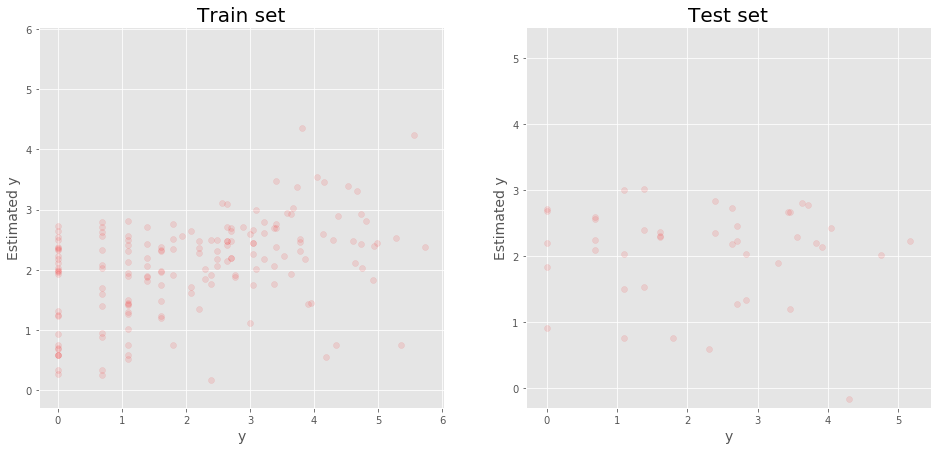

In [79]:
plot_yreal_ypred(y_test, y_train, X_test, X_train, model_huber)

In [80]:
from sklearn.linear_model import LinearRegression # подгрузили модель

# Объявили модель
model_regression = LinearRegression()

# Обучили модель на тренировочной выборке 
model_regression.fit(X_train, y_train)

# Сделали прогнозы на тестовой выборке 
y_pred_regr = model_regression.predict(X_test)

In [81]:
metrics.mean_absolute_error(y_test, y_pred_regr)

1.2962466474610728

In [87]:
from sklearn.ensemble import RandomForestRegressor

# Объявили лес из 10 деревьев 
rf = RandomForestRegressor(n_estimators=1000)

# Обучили лес 
rf.fit(X_train, y_train)

# Сделали по лесу прогнозы 
y_pred_forest = rf.predict(X_test)

In [88]:
metrics.mean_absolute_error(y_test, y_pred_forest)

1.330873821323953

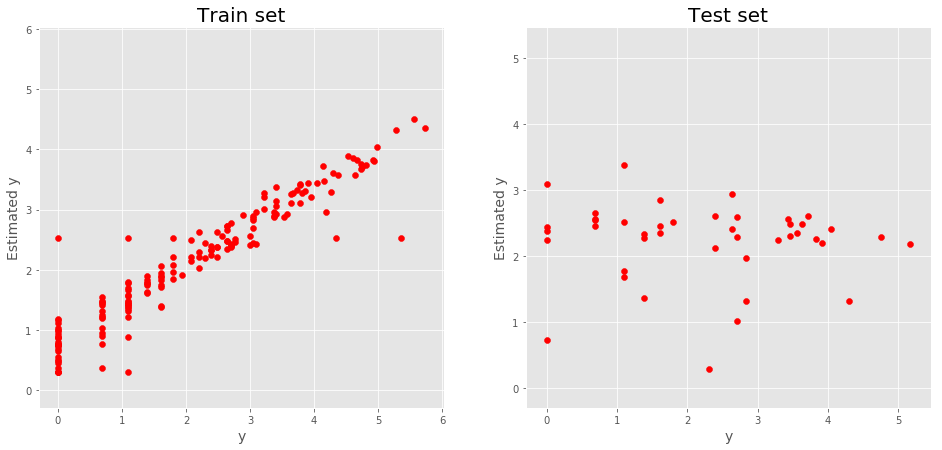

In [92]:
plot_yreal_ypred(y_test, y_train, X_test, X_train, rf)

## В дз: 

* __Подозрение:__ оч важны дамми-переменные. Странно, что наличие твиттера так сильно влияет на уменьшение лайков. Посмотрите как часто встречаются в выборке люди с твиттером. Это есть на дамми-гистограмме. Постройте её. Как думаете эта переменная правда важна? Почему? 

Попробуйте удалить из рассмотрения все дамми-переменные и оценить две регрессии: линейную и хубера. Какое у меоделей качество? Стало ли оно лучше? 

* Сформулируйте гипотезу о том, какие переменные стоит оставить или выкинуть из рассмотрения. Почему вы так считате? Оцените модель на подходящих на ваш взгляд переменных. Получилось ли улучшить качество прогнозирования? 

* Обратите внимание, что на картинке с прогнозами очень густой является область с нулевым числом лайков. Может ли быть проблема в том, что в данных есть особая нулевая точка, которую надо рассматривать отдельно и придумывать для неё свою модель? Попробуйте выкинуть из рассмотрения всех, кто поставил нулевое число лайков и построить модель только для положительного их количества. Для моделирования используйте список фичей, который вы придумали в предыдущем пункте. Дополнительно с помощью корреляции с таргетом отберите из этого списка только самые важные фичи.